# Setting up environments

In [135]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
import flax
from flax import linen as nn
import optax

# Linear regression with Flax

In [136]:
model = nn.Dense(features=5)

## Model parameters & initialization

In [137]:
key1, key2 = random.split(random.PRNGKey(0))
x = random.normal(key1, (10, ))
# model.init(PRNGKey, dummy data)
params = model.init(key2, x)
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'bias': (5,), 'kernel': (10, 5)}}

In [138]:
output, params = model.init_with_output(key2, x)
print(output.shape)
print(jax.tree_util.tree_map(lambda x: x.shape, params))

(5,)
{'params': {'bias': (5,), 'kernel': (10, 5)}}


In [139]:
model.apply(params, x)

Array([-1.4309565 ,  0.68059814, -0.47063   , -0.00443757,  0.61720204],      dtype=float32)

## Gradient descent

In [140]:
n_samples = 20
x_dim = 10
y_dim = 5

key = random.PRNGKey(0)
k1, k2 = random.split(key)
W = random.normal(k1, (x_dim, y_dim))
b = random.normal(k2, (y_dim, ))
true_params = flax.core.freeze({'params': {'bias': b, 'kernel': W}})
print(type(true_params))

key_sample, key_noise = random.split(k1)
x_samples = random.normal(key_sample, (n_samples, x_dim))
y_samples = (jnp.dot(x_samples, W) + b 
             + 0.1 * random.normal(key_noise, (n_samples, y_dim)))
print('x shape:', x_samples.shape, '; y shape:', y_samples.shape)

<class 'flax.core.frozen_dict.FrozenDict'>
x shape: (20, 10) ; y shape: (20, 5)


In [141]:
@jax.jit
def mse(params, x_batched, y_batched):
    def squared_error(x, y):
        pred = model.apply(params, x)
        return jnp.inner(y-pred, y-pred) / 2.0
    return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched))

In [142]:
learning_rate = 0.3
print('Loss for "true W, b:', mse(true_params, x_samples, y_samples))
loss_grad_fn = jax.value_and_grad(mse)

@jax.jit
def update_params(params, learning_rate, grads):
    params = jax.tree_util.tree_map(
        lambda p, g: p - learning_rate * g, params, grads)
    return params

for i in range(101):
    loss_val, grads = loss_grad_fn(params, x_samples, y_samples)
    params = update_params(params, learning_rate, grads)
    if i % 10 == 0:
        print(f'Loss step {i}:', loss_val)

Loss for "true W, b: 0.023639798
Loss step 0: 35.717175
Loss step 10: 0.52654123
Loss step 20: 0.11472414
Loss step 30: 0.037997153
Loss step 40: 0.019133301
Loss step 50: 0.013885747
Loss step 60: 0.012306851
Loss step 70: 0.011808872
Loss step 80: 0.011647595
Loss step 90: 0.011594624
Loss step 100: 0.011577098


## Optimizing with Optax

In [143]:
import optax
learning_rate = 0.3
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(mse)
params = model.init(random.PRNGKey(0), x_samples)

for i in range(101):
    loss_val, grads = loss_grad_fn(params, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print(f'Loss step {i}: {loss_val}')

Loss step 0: 35.479736328125
Loss step 10: 4.361007213592529
Loss step 20: 1.258549690246582
Loss step 30: 0.4513617157936096
Loss step 40: 0.15732677280902863
Loss step 50: 0.0579988956451416
Loss step 60: 0.02834184840321541
Loss step 70: 0.017301736399531364
Loss step 80: 0.014532424509525299
Loss step 90: 0.01267541665583849
Loss step 100: 0.011985315941274166


## Serializing the result

In [144]:
from flax import serialization
bytes_output = serialization.to_bytes(params)
dict_output = serialization.to_state_dict(params)
print('Bytes output:', bytes_output)
print('Dict output:', dict_output)

Bytes output: b'\x81\xa6params\x82\xa4bias\xc7!\x01\x93\x91\x05\xa7float32\xc4\x14\xd44\xb9\xbf\x82\xa5\x01\xc0\x1f{\x05@=[\x9c?\xb6E\x80\xbf\xa6kernel\xc7\xd6\x01\x93\x92\n\x05\xa7float32\xc4\xc8I\x8f\x80?\x88\x82=>\n\xc71=p\xdam\xbf4j\xb3>\x86\xcc\xdc?\xa9Y~?\xdd\xd0\x95?W\xc2\x8d?^~\xd9\xbd\x90\xad\x98\xbfT8\x92>\x1f\xa9\xb5?n\x9e\xfd=\x16\x1d\xa8\xbf\x86{\x98\xbf\xf5\x88?\xbe\x8e\\$=\x8cg\xa9?l\x1f\xad=X\xa5\x0c>\x1f\xfd\xae?\xaf\xd6\xa8\xbfe\xd4\t?ax\x0f\xc0\x96\x8c\x0f?\xc8\xd0P?\x96:\xa6>\x0f\xc7\t?\xc8Qg?F\xcf\xc3\xbeT\t\xdf?)\x08\x8a?\xfd\x10\x01\xbf\xf6\x14m?\xbe\xa1w?\xe8)\xa8\xbfr)\xab>&NP?\xef\xbe\x99\xbfI=\x82?\xf8-\x1f\xbf\xad\\\x89??n\xeb\xbf\xe4\x1c\xeb\xbe\x92T&\xbf\xa40\xec>\x99j\x91\xbf\xda?/\xbfR\xc2)>'
Dict output: {'params': {'bias': Array([-1.4469247, -2.0257268,  2.0856397,  1.2215344, -1.0021274],      dtype=float32), 'kernel': Array([[ 1.0043727 ,  0.18506825,  0.04340271, -0.92911434,  0.35041964],
       [ 1.7249916 ,  0.9935556 ,  1.1704365 ,  1.1074933 , 

In [145]:
# params here is a template
serialization.from_bytes(params, bytes_output)

{'params': {'bias': array([-1.4469247, -2.0257268,  2.0856397,  1.2215344, -1.0021274],
        dtype=float32),
  'kernel': array([[ 1.0043727 ,  0.18506825,  0.04340271, -0.92911434,  0.35041964],
         [ 1.7249916 ,  0.9935556 ,  1.1704365 ,  1.1074933 , -0.10619806],
         [-1.1927967 ,  0.285586  ,  1.4192237 ,  0.12383734, -1.3133876 ],
         [-1.1912696 , -0.18704589,  0.04012733,  1.3234725 ,  0.08453259],
         [ 0.13734949,  1.3670996 , -1.3190516 ,  0.53839713, -2.2417223 ],
         [ 0.5607389 ,  0.81568575,  0.32466573,  0.53819364,  0.90359163],
         [-0.38244075,  1.7424722 ,  1.078374  , -0.5041655 ,  0.9261011 ],
         [ 0.96731174, -1.3137789 ,  0.33430058,  0.81369245, -1.2011393 ],
         [ 1.0174953 , -0.6217952 ,  1.0731407 , -1.839302  , -0.4592048 ],
         [-0.64972794,  0.4613086 , -1.1360656 , -0.68456805,  0.16578034]],
        dtype=float32)}}

# Defining your own model

## Module basics

In [146]:
# nn.Module is dataclass
class ExplicitMLP(nn.Module):
    features: Sequence[int]
    
    # called at the end of __post_init__
    def setup(self):
        self.layers = [nn.Dense(feat) for feat in self.features]
        
    def __call__(self, inputs):
        x = inputs
        for i, lyr in enumerate(self.layers):
            x = lyr(x)
            if i != len(self.layers) - 1:
                x = nn.relu(x)
        return x
    

key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4, 4))

model = ExplicitMLP(features=[3, 4, 5])
params = model.init(key2, x)
y = model.apply(params, x)

print('Initialized parameter shape:\n', jax.tree_util.tree_map(jnp.shape, params))
print('Output:\n', y.shape)

Initialized parameter shape:
 {'params': {'layers_0': {'bias': (3,), 'kernel': (4, 3)}, 'layers_1': {'bias': (4,), 'kernel': (3, 4)}, 'layers_2': {'bias': (5,), 'kernel': (4, 5)}}}
Output:
 (4, 5)


In [147]:
class SimpleMLP(nn.Module):
    features: Sequence[int]
    
    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for i, feat in enumerate(self.features):
            x = nn.Dense(feat, name=f"layer_{i}")(x)
            if i != len(self.features) - 1:
                x = nn.relu(x)
        return x
        
key1, key2 = jax.random.split(jax.random.PRNGKey(0), 2)
x = jax.random.normal(key1, (4, 4))

model = SimpleMLP(features=[3, 4, 5])
params = model.init(key2, x)
y = model.apply(params, x)

print('Initialized parameters:\n', jax.tree_util.tree_map(jnp.shape, params))
print('Output shape:\n', y.shape)


Initialized parameters:
 {'params': {'layer_0': {'bias': (3,), 'kernel': (4, 3)}, 'layer_1': {'bias': (4,), 'kernel': (3, 4)}, 'layer_2': {'bias': (5,), 'kernel': (4, 5)}}}
Output shape:
 (4, 5)


## Module parameters

In [148]:
class SimpleDense(nn.Module):
    features: int
    kernel_init: Callable = nn.initializers.lecun_normal()
    bias_init: Callable = nn.initializers.zeros_init()
    
    @nn.compact
    def __call__(self, inputs):
        # Need input.shape to be in setup().
        kernel = self.param('kernel',
                            # init_fn
                            self.kernel_init,
                            # init_args to init_fn
                            (inputs.shape[-1], self.features))
        y = lax.dot_general(
            inputs, kernel,
            # ((lhs_contracting_dims, rhs_contracting_dims),
            #  (lhs_batch_dims, rhs_batch_dims))
            (((inputs.ndim - 1,), (0,)), ((), ())))
        bias = self.param('bias', self.bias_init, (self.features,))
        return y + bias
    
key1, key2 = random.split(random.PRNGKey(0), 2)
x = random.uniform(key1, (4, 4))

model = SimpleDense(features=3)
params = model.init(key2, x)
y = model.apply(params, x)

print('Initialized parameters:\n', jax.tree_map(jnp.shape, params))
print('Output shape:\n', y.shape)

Initialized parameters:
 {'params': {'bias': (3,), 'kernel': (4, 3)}}
Output shape:
 (4, 3)


## Variables and collection of variables

In [149]:
class BiasAdderWithRunningMean(nn.Module):
    decay: float = 0.99
    
    @nn.compact
    def __call__(self, x):
        is_initialized = self.has_variable('batch_stats', 'mean')
        ra_mean = self.variable('batch_stats', 'mean',
                                lambda s: jnp.zeros(s), x.shape[1:])
        
        # This probably isn't needed. 
        # https://github.com/google/flax/issues/3260
        # mean = ra_mean.value  # Either get the value or trigger init.
        
        # bias is a param while ra_mean is a variable.
        bias = self.param('bias', lambda rng, shape: jnp.zeros(shape), x.shape[1:])
        if is_initialized:
            # Without keepdims, we get (5,) instead of (1,5). Not sure if it 
            # matters though.
            ra_mean.value = self.decay * ra_mean.value + (1.0 - self.decay) * jnp.mean(x, axis=0, keepdims=True)
        return x - ra_mean.value + bias
    
key1, key2 = random.split(random.PRNGKey(0), 2)
x = jnp.ones((10,5))
model = BiasAdderWithRunningMean()
variables = model.init(key1, x)
print('Initialized variables:\n', variables)
y, updated_state = model.apply(variables, x, mutable=['batch_stats'])
print('Updated state:\n', updated_state)
    

Initialized variables:
 {'batch_stats': {'mean': Array([0., 0., 0., 0., 0.], dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}}
Updated state:
 {'batch_stats': {'mean': Array([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32)}}


How we update variables and get the new params

In [150]:
print('Initial variables:')
print(variables)
for val in [1., 2., 3.]:
    x = val * jnp.ones((10, 5))
    # model.apply() needs params and variables as input, but it returns
    # updated variables only. When there were no variables, model.apply()
    # returns y only, e.g., y = model.apply(params, x)
    y, updated_state = model.apply(variables, x, mutable=['batch_stats'])
    # Merge params and updated_state into a new variables dict.
    old_state, params = flax.core.pop(variables, 'params')
    variables = flax.core.freeze({'params': params, **updated_state})
    print('Updated state:')
    print(updated_state)
    print('Updated variables:')
    print(variables)
    print('---------------')

Initial variables:
{'batch_stats': {'mean': Array([0., 0., 0., 0., 0.], dtype=float32)}, 'params': {'bias': Array([0., 0., 0., 0., 0.], dtype=float32)}}
Updated state:
{'batch_stats': {'mean': Array([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32)}}
Updated variables:
FrozenDict({
    params: {
        bias: Array([0., 0., 0., 0., 0.], dtype=float32),
    },
    batch_stats: {
        mean: Array([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32),
    },
})
---------------
Updated state:
{'batch_stats': {'mean': Array([[0.0299, 0.0299, 0.0299, 0.0299, 0.0299]], dtype=float32)}}
Updated variables:
FrozenDict({
    params: {
        bias: Array([0., 0., 0., 0., 0.], dtype=float32),
    },
    batch_stats: {
        mean: Array([[0.0299, 0.0299, 0.0299, 0.0299, 0.0299]], dtype=float32),
    },
})
---------------
Updated state:
{'batch_stats': {'mean': Array([[0.059601, 0.059601, 0.059601, 0.059601, 0.059601]], dtype=float32)}}
Updated variables:
FrozenDict({
    params: {
        bias: Arra

When there's an optimizer

In [151]:
from functools import partial

@partial(jax.jit, static_argnums=(0, 1))
def update_step(tx, apply_fn, x, opt_state, params, state):
    
    def loss(params):
        y, updated_state = apply_fn({'params': params, **state},
                                    x, mutable=list(state.keys()))
        l = ((x - y) ** 2).sum()
        return l, updated_state
    
    (l, state), grads = jax.value_and_grad(loss, has_aux=True)(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params, state, l

x = jnp.ones((10, 5))
variables = model.init(random.PRNGKey(0), x)
state, params = flax.core.pop(variables, 'params')
del variables
tx = optax.sgd(learning_rate=0.02)
opt_state = tx.init(params)

for _ in range(3):
    opt_state, params, state, loss = update_step(
        tx, model.apply, x, opt_state, params, state)
    print('Loss:', loss)
    print('Updated state:\n', state)
    print('Params:\n', params)
    print('-------------------------')

Loss: 0.0049999906
Updated state:
 {'batch_stats': {'mean': Array([[0.01, 0.01, 0.01, 0.01, 0.01]], dtype=float32)}}
Params:
 {'bias': Array([0.004, 0.004, 0.004, 0.004, 0.004], dtype=float32)}
-------------------------
Loss: 0.012640525
Updated state:
 {'batch_stats': {'mean': Array([[0.0199, 0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32)}}
Params:
 {'bias': Array([0.01036, 0.01036, 0.01036, 0.01036, 0.01036], dtype=float32)}
-------------------------
Loss: 0.0187037
Updated state:
 {'batch_stats': {'mean': Array([[0.029701, 0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32)}}
Params:
 {'bias': Array([0.0180964, 0.0180964, 0.0180964, 0.0180964, 0.0180964], dtype=float32)}
-------------------------


## TrainState

See [TrainState](https://flax.readthedocs.io/en/latest/_modules/flax/training/train_state.html#TrainState) use below for encapsulating params and optax.

In [152]:
x_key, noise_key, model_key = jax.random.split(jax.random.PRNGKey(0), 3)
xs = jax.random.normal(x_key, (100, 1))
noise = jax.random.normal(noise_key, (100, 1))
W, b = 2, -1
ys = xs + noise + b

@jax.jit
def apply_model(state, xs, ys):

    def loss_fn(params, xs, ys):
        # Can't use {'params': state.params} here because it then
        # is not functional.
        yhats = state.apply_fn({'params': params}, xs)
        loss = jnp.mean((ys - yhats) ** 2)
        return loss

    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, xs, ys)
    return loss, grads

@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

class SingleLayerDNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1)(x)
        return x
    
model = SingleLayerDNN()
params = model.init(model_key, xs)['params']

state = TrainState.create(apply_fn=model.apply, params=params, tx=optax.sgd(0.005))
for i in range(1001):
    loss, grads = apply_model(state, xs, ys)
    state = update_model(state, grads)
    if i % 100 == 0:
        print(f'Loss @ {i}:', loss)

Loss @ 0: 4.21584
Loss @ 100: 1.5112355
Loss @ 200: 1.2084138
Loss @ 300: 1.1742883
Loss @ 400: 1.1704139
Loss @ 500: 1.16997
Loss @ 600: 1.1699189
Loss @ 700: 1.1699128
Loss @ 800: 1.1699121
Loss @ 900: 1.1699121
Loss @ 1000: 1.1699121


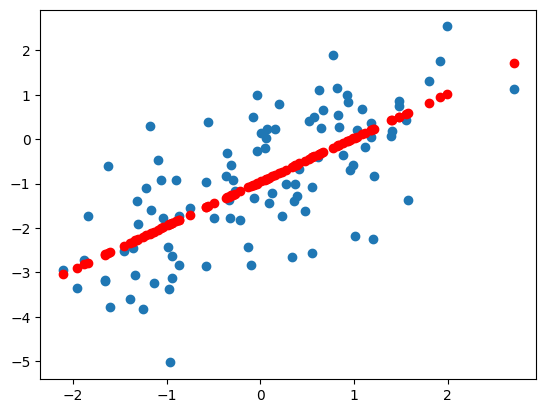

In [153]:
import matplotlib.pyplot as plt

plt.scatter(xs, ys)
yhats = state.apply_fn({'params': state.params}, xs)
plt.scatter(xs, yhats, c='r')
plt.show()